# Performance analysis on synthetic data generators

This notebooks applies multiple synthetic data generator to simulate the real data set, Complete Journey. We provide step-by-step instructions on how to use each generator and analyze their performance from perspectives of Fidelity, Utility, and Privacy.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import logging
import pickle
import json

from syncomp.metrics.fidelity import (
    gather_fidelity_info_from_df,
    compare_fidelity_info
)
from syncomp.metrics.utility import (
    get_regression_training_data,
    get_classification_training_data,
    train_eval_model
)
from syncomp.utils.data_util import CompleteJourneyDataset
from syncomp.utils.viz_util import plot_heatmap, plot_hist
from syncomp.utils.holdout_util import split_dataframe
from syncomp.utils.train_util import train_autodiff, train_ctgan
from syncomp.metrics.privacy import distance_closest_record, evaluate_tapas_attack

logging.getLogger().setLevel(logging.INFO)

%reload_ext autoreload
%autoreload 2

## Real Data Exploration

> The Complete Journey dataset characterizes household level transactions over one year from a group of 2,469 households who are frequent shoppers at a grocery store. It contains all of each household’s purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are captured.

For a deep dive into the dataset exploration and data cleaning, please refer to notebook [Complete Journey Data Exploration](https://github.com/RetailMarketingAI/retailsynth/blob/main/analysis_workflow/1_complete_journey_eda/1_preprocess_analysis.ipynb).

In [7]:
# TODO: Show distributions of some key categorical variables and numerical variables we're gonna use to evaluate the model.

In [9]:
# read real df and synthetic df
cd = CompleteJourneyDataset()
real_df = cd.run_preprocess()
train_df, holdout_df, eval_df = split_dataframe(real_df, [0.4, 0.4, 0.2])

INFO:root:Filter out transactions with non-positive quantity sold or money spent. Number of transactions are decreased to 1458032.
INFO:root:Use the same label for products with the same hierarchy information. Number of products are decreased to 32333.
INFO:root:Filter out transactions with invalid customer id. Number of transactions are decreased to 730640.
INFO:root:Filter out transactions with extreme large quantity sold. Number of transactions are decreased to 723742.
INFO:root:Remove 16271 products with few transactions. Number of transactions are decreased to 644084.
INFO:root:Combine 4643 products with few transactions to belong to one category.


In [10]:
train_df.dtypes

product_id                        object
household_id                      object
week                              object
quantity                           int64
sales_value                      float64
retail_disc                      float64
coupon_disc                      float64
coupon_match_disc                float64
unit_price                       float64
base_price                       float64
retail_discount_portion          float64
coupon_discount_portion          float64
coupon_match_discount_portion    float64
manufacturer_id                   object
department                        object
brand                             object
product_category                  object
product_type                      object
package_size                      object
age                               object
income                            object
home_ownership                    object
marital_status                    object
household_size                    object
household_comp  

In [11]:
# TODO: divide by week and fit each one for different weeks
# TODO: list out the preprocessing pipeline for each model

## Models [2/8 Implmentation Done]
1. StaSy: https://github.com/JayoungKim408/STaSy?tab=readme-ov-file
2. TabDDPM: https://github.com/yandex-research/tab-ddpm/tree/main
3. AutoGAN: https://github.com/VITA-Group/AutoGAN
4. StaSy-AutoDiff: need to write implementation myself?
5. Med-AutoDiff: need to write implementation myself? https://github.com/mp2893/medgan
6. [DONE] Tab-AutoDiff
7. [DONE] CTGAN: https://github.com/sdv-dev/CTGAN
8. [DONE] CTAB-GAN: https://github.com/Team-TUD/CTAB-GAN

In [13]:
# generate one syn_df using autodiff
# syn_df, time_duration = train_autodiff(train_df=train_df)
syn_df = cd.load_data('../results/AutoDiff/0/synthetic_data.csv')

## Metrics

### Fidelity [Implementation Done]
1. Wasserstein distance of probability distributions for the following numerical features:
    - Store visit probability
    - Product purchase probability
    - Product demand
    - Basket size
    - Time between purchase
    - Price elasticity
2. Jensen Shannon divergence of distributions for the following categorical features:
    - Customer demographics (age, household size, etc.)
    - Store information (state, city, etc.)
3. Pearson Correlation between listed numerical features
4. Theil's U for listed categorical features
5. Correlation Ratio between listed categorical and numerical features
6. Business insights
    - Customer segmentation
    - Customer retention
    - Category penetration

In [14]:
fidelity_json = []
for i in range(3):
    with open('../results/AutoDiff/0/fidelity_metric.json', 'r') as f:
        score = json.load(f)
        fidelity_json.append(score)

In [15]:
def compute_mean(objects):
    def recursive_mean(obj_list):
        if isinstance(obj_list[0], dict):
            keys = obj_list[0].keys()
            return {k: recursive_mean([d[k] for d in obj_list]) for k in keys}
        elif isinstance(obj_list[0], list):
            return [recursive_mean([item[i] for item in obj_list]) for i in range(len(obj_list[0]))]
        else:
            return sum(obj_list) / len(obj_list)

    return recursive_mean(objects)

mean_result = compute_mean(fidelity_json)

print(json.dumps(mean_result, indent=4))

{
    "syn_df": {
        "wasserstein_distance": {
            "visit_prob_per_store": 0.18630249774923557,
            "purchase_prob_per_product": 0.14096420700836435,
            "basket_size_per_product": 138.11100000000002,
            "time_between_purchase_per_customer": 0.7017916218634873,
            "customer_retention_per_store": 0.0,
            "category_penetration_per_category": 0.0596778930194003,
            "unit_price": 0.6253605024059614,
            "base_price": 0.8997242517686231,
            "revenue": 1.428219770962001,
            "quantity": 5.137000000000004
        },
        "jensenshannon_distance": {
            "age": 0.39835495785254155,
            "income": 0.4072239491152852,
            "household_size": 0.28142825882556155,
            "kids_count": 0.28053799335337254,
            "product_category": 0.30770487781966577,
            "department": 0.5335734324570496
        },
        "euclidean_distance": {
            "pearson_coef": 1.23855256

In [16]:
with open('../results/AutoDiff/0/fidelity_info.pkl', 'rb') as f:
    fidelity_info_0 = pickle.load(f)
(
    train_fidelity_info, syn_fidelity_info, holdout_fidelity_info
) = fidelity_info_0["train_df"], fidelity_info_0["syn_df"], fidelity_info_0["holdout_df"] 

Text(0.5, 1.0, 'Holdout vs Real Revenue')

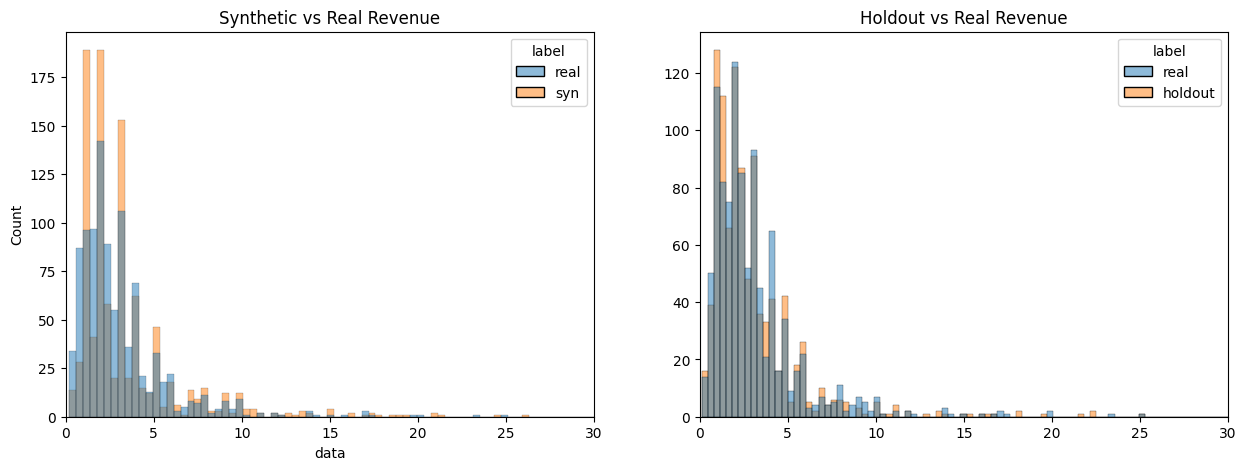

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_hist(train_fidelity_info["numerical"]["revenue"], syn_fidelity_info["numerical"]["revenue"], ax=ax1)
ax1.set_xlim(0, 30)
ax1.set_title("Synthetic vs Real Revenue")
plot_hist(train_fidelity_info["numerical"]["revenue"], holdout_fidelity_info["numerical"]["revenue"], syn_name='holdout', ax=ax2,)
ax2.set_xlim(0, 30)
ax2.set_title("Holdout vs Real Revenue")

Text(0.5, 1.0, 'Holdout vs Real Revenue')

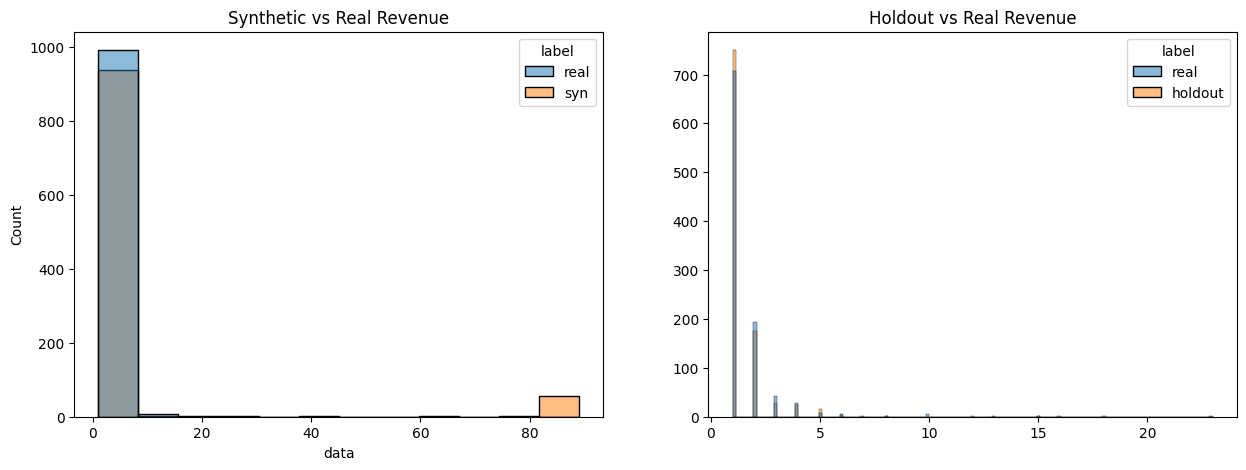

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_hist(train_fidelity_info["numerical"]["quantity"], syn_fidelity_info["numerical"]["quantity"], ax=ax1)
# ax1.set_xlim(0, 30)
ax1.set_title("Synthetic vs Real Revenue")
plot_hist(train_fidelity_info["numerical"]["quantity"], holdout_fidelity_info["numerical"]["quantity"], ax=ax2, syn_name="holdout")
# ax2.set_xlim(0, 30)
ax2.set_title("Holdout vs Real Revenue")

In [19]:
train_fidelity_info["numerical"].keys()

dict_keys(['visit_prob_per_store', 'purchase_prob_per_product', 'basket_size_per_product', 'time_between_purchase_per_customer', 'customer_retention_per_store', 'category_penetration_per_category', 'unit_price', 'base_price', 'revenue', 'quantity'])

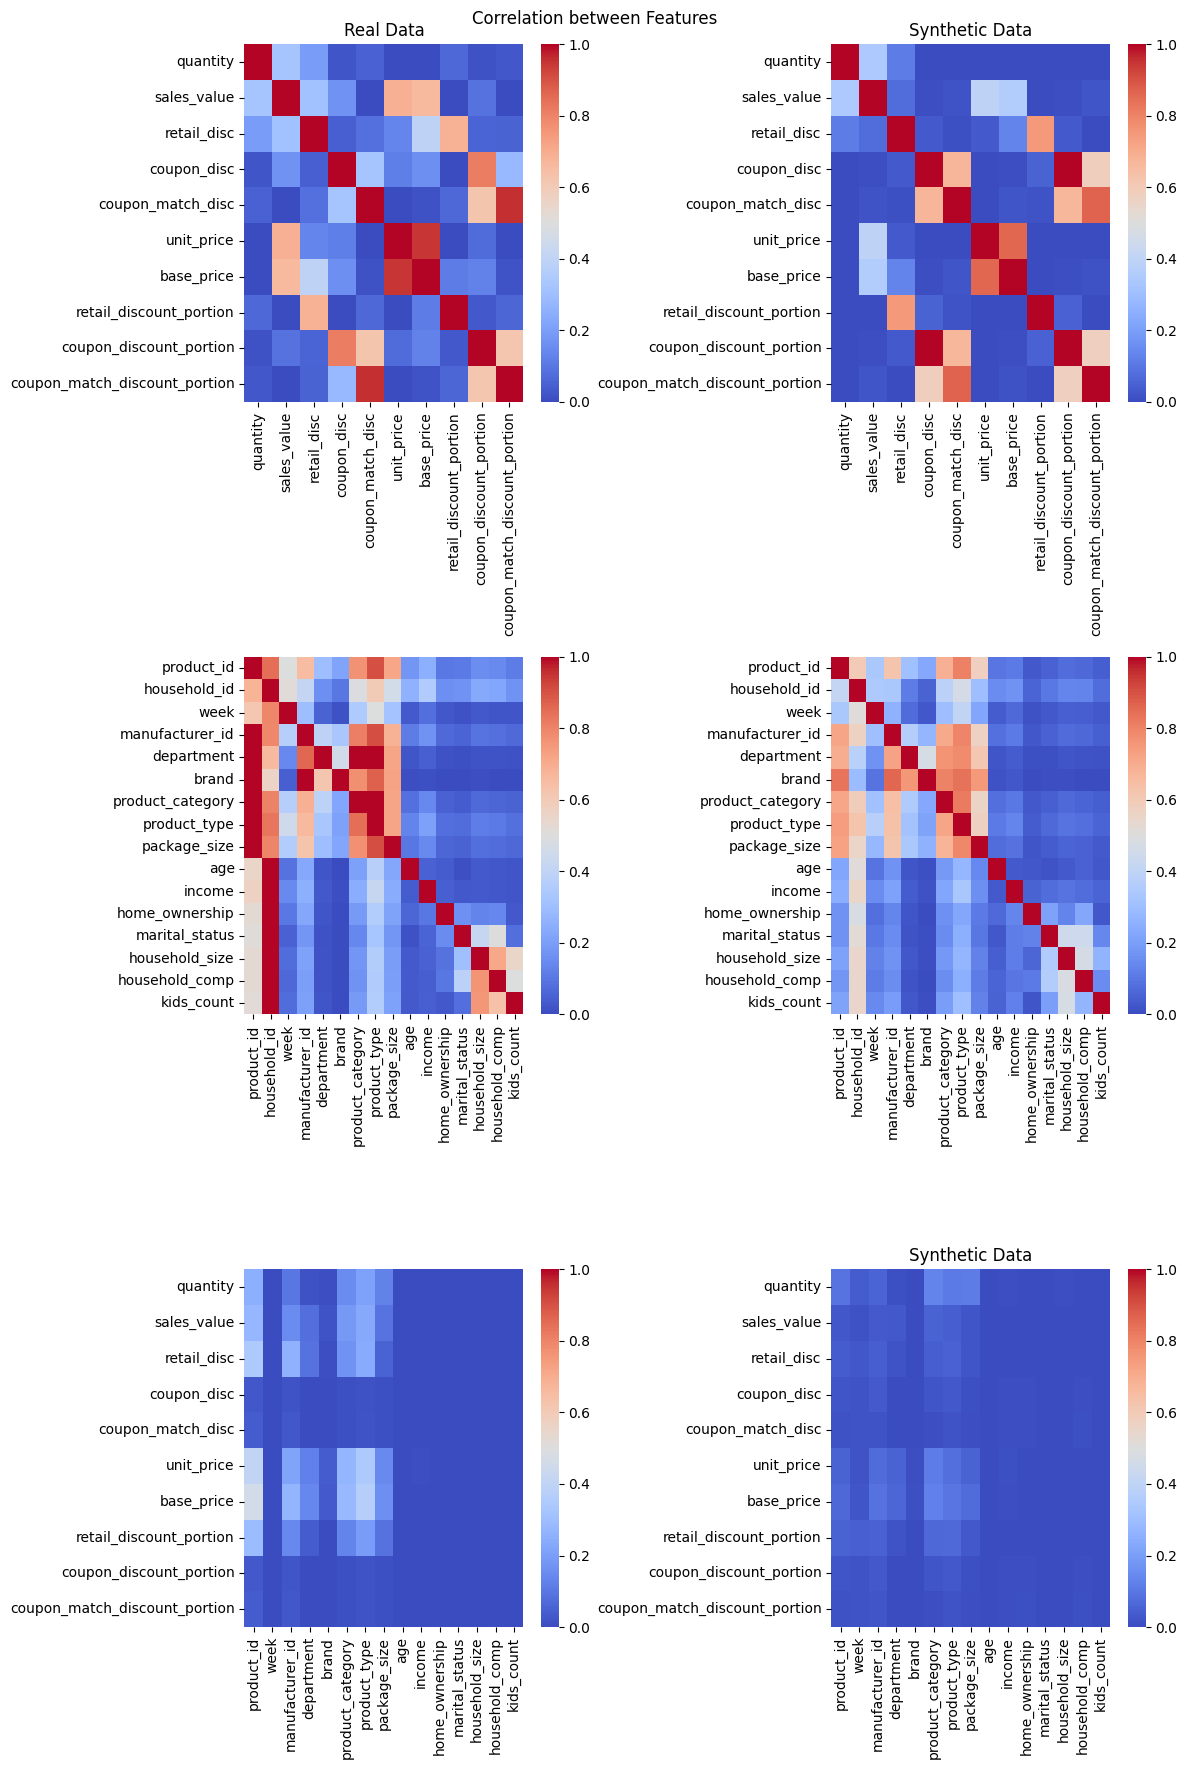

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
ax1, ax2 = axes[0]
plot_heatmap(train_fidelity_info["interaction"]['pearson_coef'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(syn_fidelity_info["interaction"]['pearson_coef'], ax=ax2, title='Synthetic Data', vmin=0, vmax=1)
ax1.set_title('Real Data')
ax2.set_title('Synthetic Data')
ax1, ax2 = axes[1]
plot_heatmap(train_fidelity_info["interaction"]['theils_u'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(syn_fidelity_info["interaction"]['theils_u'], ax=ax2, title='Synthetic Data', vmin=0, vmax=1)
ax1, ax2 = axes[2]
plot_heatmap(train_fidelity_info["interaction"]['correl_ratio'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(syn_fidelity_info["interaction"]['correl_ratio'], ax=ax2, title='Synthetic Data', vmin=0, vmax=1)

plt.suptitle('Correlation between Features')
plt.tight_layout()

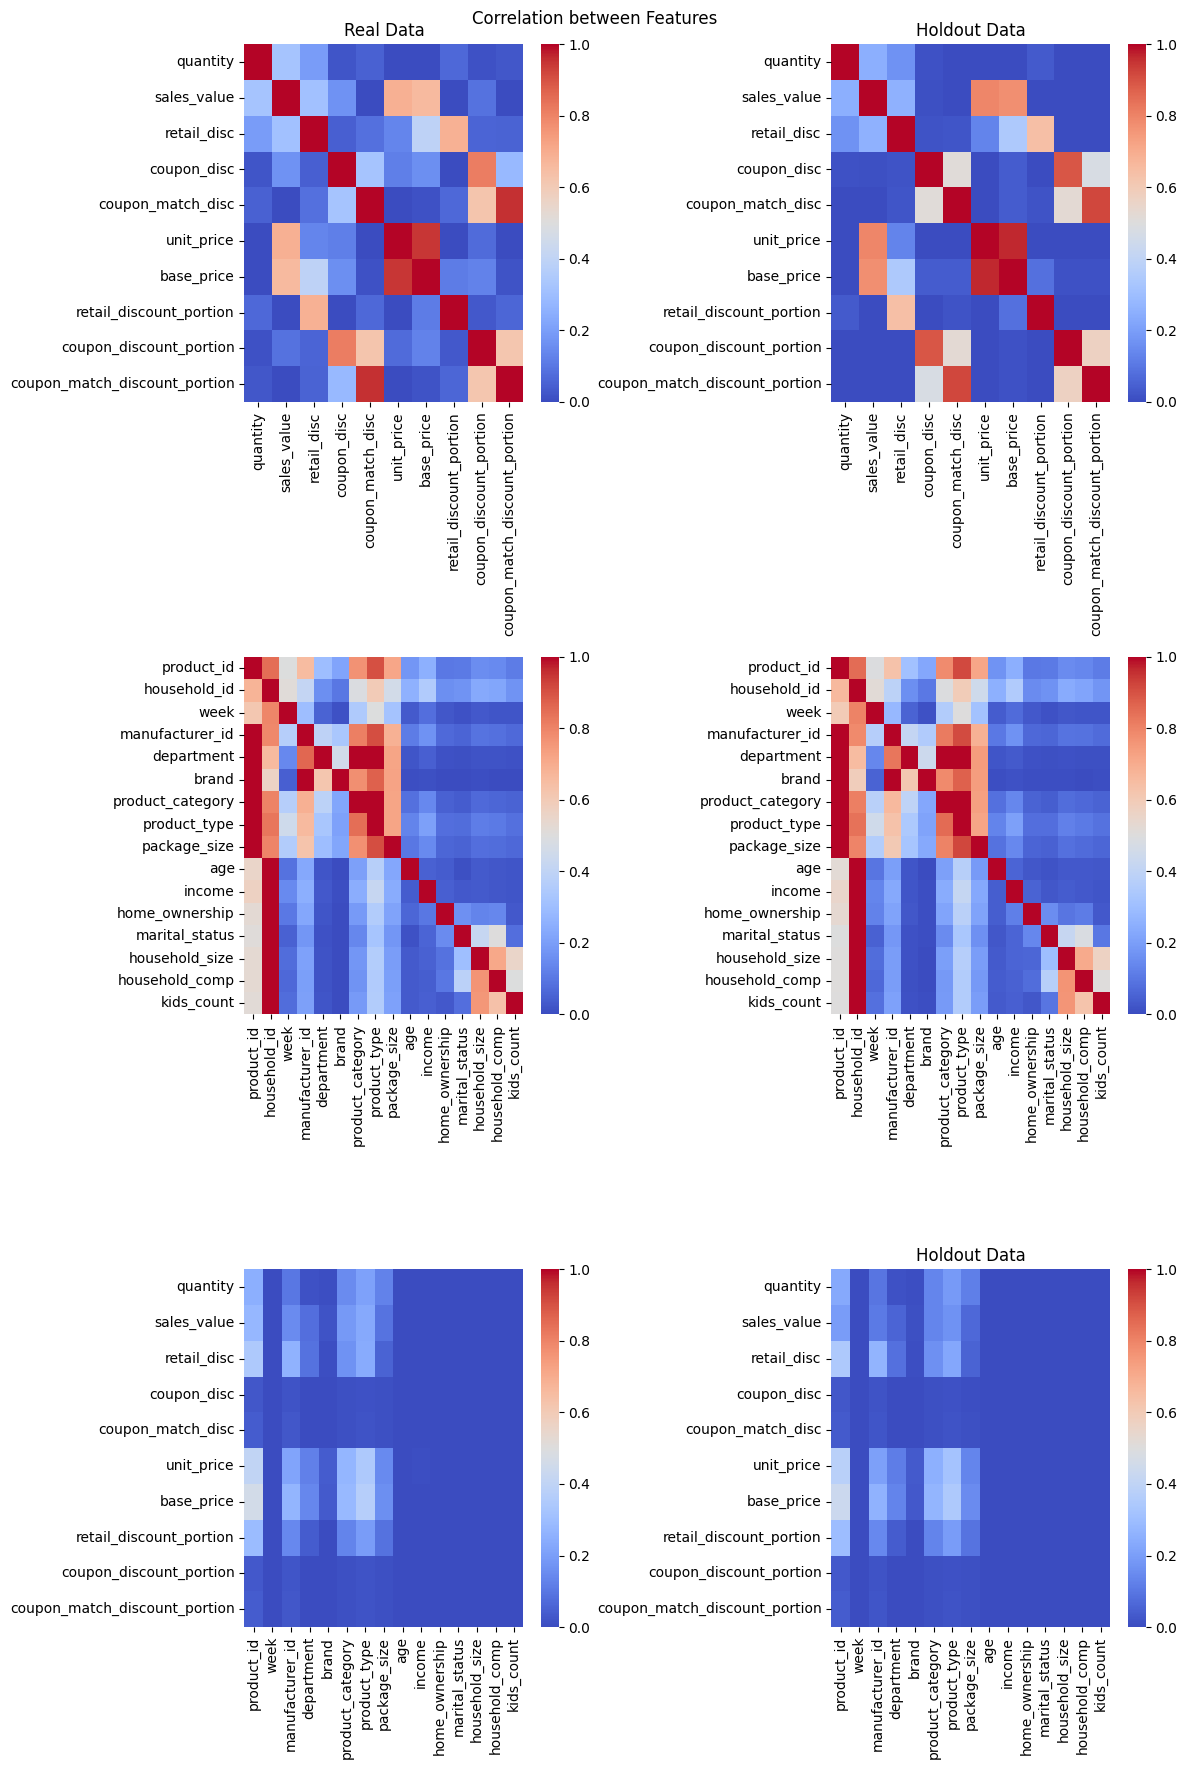

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
ax1, ax2 = axes[0]
plot_heatmap(train_fidelity_info["interaction"]['pearson_coef'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(holdout_fidelity_info["interaction"]['pearson_coef'], ax=ax2, title='Holdout Data', vmin=0, vmax=1)
ax1.set_title('Real Data')
ax2.set_title('Holdout Data')
ax1, ax2 = axes[1]
plot_heatmap(train_fidelity_info["interaction"]['theils_u'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(holdout_fidelity_info["interaction"]['theils_u'], ax=ax2, title='Holdout Data', vmin=0, vmax=1)
ax1, ax2 = axes[2]
plot_heatmap(train_fidelity_info["interaction"]['correl_ratio'], ax=ax1, title='Real Data', vmin=0, vmax=1)
plot_heatmap(holdout_fidelity_info["interaction"]['correl_ratio'], ax=ax2, title='Holdout Data', vmin=0, vmax=1)

plt.suptitle('Correlation between Features')
plt.tight_layout()

### Utility [Implementation Done]
We define a classification task and a regression task to justify if statistical ML models can learn the patterns from the synthetic data. Classification task is to predict whether the customer purchase more than 10 products per day. Regression task is to predict the total demand or revenue of a customer at one time step. 
1. Classification task
    - Accuracy
    - F1 score
    - ROC AUC
    - Precision-Recall

2. Regression task
    - Mean Squared Error
    - R2 score

In [22]:
utility_json = []
for i in range(3):
    with open('../results/AutoDiff/0/utility_metrics.json', 'r') as f:
        score = json.load(f)
        utility_json.append(score)

In [23]:
mean_result = compute_mean(utility_json)

print(json.dumps(mean_result, indent=4))

# TODO: use forest based classifier, avoid linear model on syn_df

# TODO: check the distribution of the target variable in the real, synthetic, holdout data

{
    "classification": {
        "train_df": {
            "accuracy": 0.6245850811599489,
            "f1": 0.3559449311639549,
            "roc": 0.5698648342543319,
            "precision": 0.2855995179754971,
            "recall": 0.4722683493855862
        },
        "holdout_df": {
            "accuracy": 0.6335947474010578,
            "f1": 0.3491220112745415,
            "roc": 0.5666892361812139,
            "precision": 0.2862607586866433,
            "recall": 0.44735968116904684
        },
        "syn_df": {
            "accuracy": 0.7803392303483494,
            "f1": 0.0,
            "roc": 0.5,
            "precision": 0.0,
            "recall": 0.0
        }
    },
    "regression": {
        "train_df": {
            "mse": 76.50283989706101,
            "r2": -0.8108391064315287
        },
        "holdout_df": {
            "mse": 76.97357141618451,
            "r2": -0.8219814253912658
        },
        "syn_df": {
            "mse": 93.79640815594384,
         

### Privacy [Implementation Done]
1. Distances to Closest Records
2. TAPAS: https://github.com/alan-turing-institute/tapas

In [24]:
privacy_json = []
for i in range(3):
    with open('../results/AutoDiff/0/privacy_metrics.json', 'r') as f:
        score = json.load(f)
        privacy_json.append(score)

In [25]:
mean_result = compute_mean(privacy_json)
print(json.dumps(mean_result, indent=4))

{
    "dcr": 20.153310338394586
}


In [26]:
syn_df.columns

Index(['product_id', 'household_id', 'week', 'quantity', 'sales_value',
       'retail_disc', 'coupon_disc', 'coupon_match_disc', 'unit_price',
       'base_price', 'retail_discount_portion', 'coupon_discount_portion',
       'coupon_match_discount_portion', 'manufacturer_id', 'department',
       'brand', 'product_category', 'product_type', 'package_size', 'age',
       'income', 'home_ownership', 'marital_status', 'household_size',
       'household_comp', 'kids_count'],
      dtype='object')

1. segment df by id or cluster by customer segment
    - could cluster customer segment by historical records, demographics
    - could evaluate the cluster according to the utility score
2. fit each segment and get syn_df
3. combine all syn_df to get one syn_df

# Issues & Next Step

1. Limited computing resource:
    - It takes 1h to train the CTGAN model with only 10 training epochs using mini batches
    - Tapas attack analysis was stuck.
2. Add metrics ratio (syn_metric / holdout_metric)